# Intro

A classifier was trained (and pickled) using all the vectors in *data/bccba/VECTOR/Roi_Para_Clasificar/*

Now all the image will be classified and the vector in *data/bccba/VECTOR/CLASIFICACION_PuntosControl/* will be used to asses the results.

To use that vector, we need to modify it: the classes names are strings and we need to match them with the numer


In [1]:
%matplotlib notebook
import numpy as np
import os
import pickle
import sys

from matplotlib import pyplot as plt
from osgeo import gdal, ogr
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from landsat8 import write_geotiff

gdal.UseExceptions()


def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()


# ###############################################
# Starts testing code
# ###############################################
TEST_TO_TRAIN_CLASS_NAME = {
    'MZ': 'MAIZ',
    'MN': 'MANI',
    'PN': 'PN',
    'SJ': 'SOJA',
    'SRG': 'SORGO',
}

def test_class_name_to_train_label(class_name, training_reference):
    """Convert the test class name to the label assigned to the pixels during training."""
    # training_reference must be reference dict generated during the training process. 
    return training_reference[TEST_TO_TRAIN_CLASS_NAME[class_name]]
    

def extract_test_mask(vector_data_path, geo_transform, projection):
    """
    Rasterize our modified vector.
    """
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    if data_source is None:
        report_and_exit("File read failed: %s", vector_data_path)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=reference"])
    return target_ds


def add_label_from_reference_name(vector_data_path, training_reference):
    """
    Add a new attribute to the given vector file's geometries, converting the test class name in
    ROI_E_14_1 to the corresponding training class label.
    
    NOTE: The given vector file is modified.
    
    """
    ds = gdal.OpenEx(vector_data_path, gdal.OF_UPDATE)
    if ds is None:
        print("Open failed.")
        sys.exit(1)
    lyr = ds.GetLayer()

    lyr.ResetReading()
    lyr_defn = lyr.GetLayerDefn()
    
    new_field_defn = ogr.FieldDefn("reference", ogr.OFTInteger)

    if lyr.CreateField ( new_field_defn ) != 0:
        raise Error("Creating reference_label field failed.")
    
    field_roi_e_14_1 = lyr_defn.GetFieldIndex('ROI_E_14_1')
    field_reference_label = lyr_defn.GetFieldIndex('reference')
    for feat in lyr:
        field_roi = feat.GetField(field_roi_e_14_1)
        field_reference = feat.GetField(field_reference_label)
        reference_label = test_class_name_to_train_label(field_roi, training_reference)
        
        feat.SetField(field_reference_label, reference_label)
        lyr.SetFeature(feat)
    ds = None
# ###############################################
# End testing code
# ###############################################

data_date = "150201"
raster_data_path = "data/bccba/RASTER/L8_229_82_%s.tif" % data_date
trained_classifier_path = "classifier_trained_%s.pickle" % data_date

In [2]:
print("Reading the input: %s" % raster_data_path)
try:
    raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
except RuntimeError as e:
    report_and_exit(str(e))

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount + 1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
# A sample is a vector with all the bands data. Each pixel (independent of its position) is a
# sample.
n_samples = rows * cols

Reading the input: data/bccba/RASTER/L8_229_82_150201.tif


# Classification

In [3]:
with open(trained_classifier_path, 'rb') as trained_classifier_file:
    training = pickle.load(trained_classifier_file)

classifier = training['classifier']
training_reference = training['reference']

In [4]:
training_reference

{'ALFA': 1,
 'MAIZ': 5,
 'MANI': 2,
 'MONTE': 3,
 'PN': 4,
 'RASTROJO': 6,
 'SOJA': 7,
 'SORGO': 8}

Predict by chunks

In [5]:
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = np.array([])
chunk_size = 100  # Number of rows
chunk_nr = 0
while chunk_nr*chunk_size < rows:
    start = chunk_nr*cols*chunk_size
    end  = start + cols*chunk_size
    chunk = flat_pixels[start: end]
    predicted_chunk = classifier.predict(chunk)
    result = np.concatenate([result, predicted_chunk])
    chunk_nr += 1

In [6]:
classification = result.reshape((rows, cols))

<IPython.core.display.Javascript object>


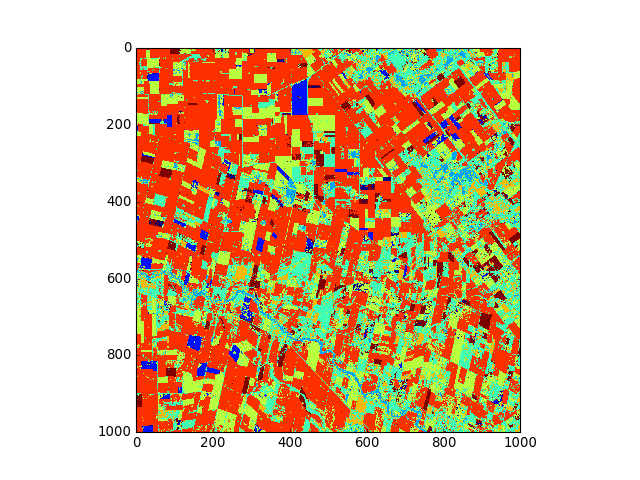

In [7]:
plt.figure()
plt.imshow(classification[5000:6000, 5000:6000], interpolation='none')

In [8]:
output_fname = "classification_%s.tiff" % data_date
write_geotiff(output_fname, classification, geo_transform, proj)
print("Classification created: %s" % output_fname)

Classification created: classification_150201.tiff


# Verification/Test

In [9]:
verification_vector_data_path = "data/bccba/VECTOR/CLASIFICACION_PuntosControl/CLASIFICACION_Y_ROI.shp"
# Esto se hace una sola vez
add_label_from_reference_name(verification_vector_data_path, training_reference)

In [10]:
test_ds = extract_test_mask(verification_vector_data_path, geo_transform, proj)

In [11]:
test_band = test_ds.GetRasterBand(1)
labeled_pixels = test_band.ReadAsArray()

In [12]:
output_fname = "verification_%s.tiff" % data_date
write_geotiff(output_fname, labeled_pixels, geo_transform, proj)
print("Verification image created: %s" % output_fname)

Verification image created: verification_150201.tiff


In [13]:
for klass, label in training_reference.items():
    print("%s [%i]: %i test pixels" % (klass, label, labeled_pixels[labeled_pixels==label].shape[0]))
    print("%s [%i]: %i predicted pixels" % (klass, label, classification[classification==label].shape[0]))

ALFA [1]: 0 test pixels
ALFA [1]: 178524 predicted pixels
MONTE [3]: 0 test pixels
MONTE [3]: 20966237 predicted pixels
MAIZ [5]: 26805 test pixels
MAIZ [5]: 5487058 predicted pixels
MANI [2]: 9122 test pixels
MANI [2]: 295019 predicted pixels
RASTROJO [6]: 0 test pixels
RASTROJO [6]: 11000040 predicted pixels
SOJA [7]: 94761 test pixels
SOJA [7]: 9686832 predicted pixels
PN [4]: 1322 test pixels
PN [4]: 11020767 predicted pixels
SORGO [8]: 3263 test pixels
SORGO [8]: 1101739 predicted pixels


In [14]:
for_verification = labeled_pixels.nonzero()
verification_labels = labeled_pixels[for_verification]
predicted_labels = classification[for_verification]

In [15]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [16]:
train_classes = sorted(training_reference, key= lambda x: training_reference[x])
train_to_test = {train_name: test_name for test_name, train_name in TEST_TO_TRAIN_CLASS_NAME.items()}
classes_labels = [train_to_test.get(c, c[:3]) for c in train_classes]
print_cm(cm, classes_labels)


   	ALF	 MN	MON	 PN	 MZ	RAS	 SJ	SRG	
ALF	  0	  0	  0	  0	  0	  0	  0	  0	
 MN	333	5220	  5	359	2729	 15	202	259	
MON	  0	  0	  0	  0	  0	  0	  0	  0	
 PN	  0	  0	  8	711	 18	577	  0	  8	
 MZ	 30	 58	636	4684	18737	2026	534	100	
RAS	  0	  0	  0	  0	  0	  0	  0	  0	
 SJ	169	 97	215	10537	5584	1658	75516	985	
SRG	156	267	  5	403	709	 38	334	1351	


In [17]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 0.750593


In [18]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))

Classification report:
             precision    recall  f1-score   support

        ALF       0.00      0.00      0.00         0
         MN       0.93      0.57      0.71      9122
        MON       0.00      0.00      0.00         0
         PN       0.04      0.54      0.08      1322
         MZ       0.67      0.70      0.69     26805
        RAS       0.00      0.00      0.00         0
         SJ       0.99      0.80      0.88     94761
        SRG       0.50      0.41      0.45      3263

avg / total       0.90      0.75      0.81    135273



/home/carlos/.virtualenvs/satimg/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
